In [1]:
#!pip install imblearn

In [2]:
import pandas as pd
from joblib import dump, load
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
import scipy as sp
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import seaborn as sns

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
"""
## expired patients
print(sum(test_data.discharge_disposition_id.isin([11,19,20,21])))
print(sum(train_data.discharge_disposition_id.isin([11,19,20,21])))
print(train_data.loc[train_data.discharge_disposition_id.isin([11,19,20,21]), 'readmitted'].value_counts())"""

"\n## expired patients\nprint(sum(test_data.discharge_disposition_id.isin([11,19,20,21])))\nprint(sum(train_data.discharge_disposition_id.isin([11,19,20,21])))\nprint(train_data.loc[train_data.discharge_disposition_id.isin([11,19,20,21]), 'readmitted'].value_counts())"

In [5]:
def replace_question_mark_with_nan(train_data, test_data):
    train_data = train_data.replace("?", np.nan)
    test_data = test_data.replace("?", np.nan)
    return train_data, test_data

In [6]:
def drop_no_variance_features(train_data, test_data):
    train_data = train_data.drop(['examide', 'citoglipton'], axis=1)
    test_data = test_data.drop(['examide', 'citoglipton'], axis=1)
    return train_data, test_data

In [7]:
def drop_duplicated_patients_in_training(train_data):
    train_data = train_data.drop_duplicates(subset=['patient_nbr'])
    return train_data

In [8]:
def drop_columns_with_lots_of_missing_data(train_data, test_data):
    train_data = train_data.drop(['weight', 'payer_code', 'medical_specialty'], axis = 1)
    test_data = test_data.drop(['weight', 'payer_code', 'medical_specialty'], axis = 1)
    return train_data, test_data

In [9]:
def remove_missing_gender_values(train_data, test_data):
    train_data["gender"] = train_data["gender"].replace("Unknown/Invalid","Female")
    test_data["gender"] = test_data["gender"].replace("Unknown/Invalid","Female")
    return train_data, test_data

In [10]:
def fill_missing_diag_values(train_data, test_data):
    train_data['diag_1'] = train_data['diag_1'].fillna(train_data['diag_1'].mode())
    train_data['diag_2'] = train_data['diag_2'].fillna(train_data['diag_2'].mode())
    train_data['diag_3'] = train_data['diag_3'].fillna(train_data['diag_3'].mode())
    
    test_data['diag_1'] = test_data['diag_1'].fillna(train_data['diag_1'].mode())
    test_data['diag_2'] = test_data['diag_2'].fillna(train_data['diag_2'].mode())
    test_data['diag_3'] = test_data['diag_3'].fillna(train_data['diag_3'].mode())
    
    train_data = encode_diag_columns(train_data)
    test_data = encode_diag_columns(test_data)
    return train_data, test_data

In [11]:
def encode_diag_columns(df):
    df.loc[df['diag_1'].str.contains('V') | df['diag_1'].str.contains('E'), ['diag_1', 'level_diag1']] = 0
    df.loc[df['diag_2'].str.contains('V') | df['diag_2'].str.contains('E'), ['diag_2', 'level_diag2']] = 0
    df.loc[df['diag_3'].str.contains('V') | df['diag_3'].str.contains('E'), ['diag_3', 'level_diag3']] = 0
    df['level_diag1'] = df['diag_1'].astype(float)
    df['level_diag2'] = df['diag_2'].astype(float)
    df['level_diag3'] = df['diag_3'].astype(float)
    for index, row in df.iterrows():
        if (row['level_diag1'] >= 390 and row['level_diag1'] < 460) or (np.floor(row['level_diag1']) == 785):
            df.loc[index, 'level_diag1'] = 1
        elif (row['level_diag1'] >= 460 and row['level_diag1'] < 520) or (np.floor(row['level_diag1']) == 786):
            df.loc[index, 'level_diag1'] = 2
        elif (row['level_diag1'] >= 520 and row['level_diag1'] < 580) or (np.floor(row['level_diag1']) == 787):
            df.loc[index, 'level_diag1'] = 3
        elif (np.floor(row['level_diag1']) == 250):
            df.loc[index, 'level_diag1'] = 4
        elif (row['level_diag1'] >= 800 and row['level_diag1'] < 1000):
            df.loc[index, 'level_diag1'] = 5
        elif (row['level_diag1'] >= 710 and row['level_diag1'] < 740):
            df.loc[index, 'level_diag1'] = 6
        elif (row['level_diag1'] >= 580 and row['level_diag1'] < 630) or (np.floor(row['level_diag1']) == 788):
            df.loc[index, 'level_diag1'] = 7
        elif (row['level_diag1'] >= 140 and row['level_diag1'] < 240):
            df.loc[index, 'level_diag1'] = 8
        else:
            df.loc[index, 'level_diag1'] = 0

        if (row['level_diag2'] >= 390 and row['level_diag2'] < 460) or (np.floor(row['level_diag2']) == 785):
            df.loc[index, 'level_diag2'] = 1
        elif (row['level_diag2'] >= 460 and row['level_diag2'] < 520) or (np.floor(row['level_diag2']) == 786):
            df.loc[index, 'level_diag2'] = 2
        elif (row['level_diag2'] >= 520 and row['level_diag2'] < 580) or (np.floor(row['level_diag2']) == 787):
            df.loc[index, 'level_diag2'] = 3
        elif (np.floor(row['level_diag2']) == 250):
            df.loc[index, 'level_diag2'] = 4
        elif (row['level_diag2'] >= 800 and row['level_diag2'] < 1000):
            df.loc[index, 'level_diag2'] = 5
        elif (row['level_diag2'] >= 710 and row['level_diag2'] < 740):
            df.loc[index, 'level_diag2'] = 6
        elif (row['level_diag2'] >= 580 and row['level_diag2'] < 630) or (np.floor(row['level_diag2']) == 788):
            df.loc[index, 'level_diag2'] = 7
        elif (row['level_diag2'] >= 140 and row['level_diag2'] < 240):
            df.loc[index, 'level_diag2'] = 8
        else:
            df.loc[index, 'level_diag2'] = 0

        if (row['level_diag3'] >= 390 and row['level_diag3'] < 460) or (np.floor(row['level_diag3']) == 785):
            df.loc[index, 'level_diag3'] = 1
        elif (row['level_diag3'] >= 460 and row['level_diag3'] < 520) or (np.floor(row['level_diag3']) == 786):
            df.loc[index, 'level_diag3'] = 2
        elif (row['level_diag3'] >= 520 and row['level_diag3'] < 580) or (np.floor(row['level_diag3']) == 787):
            df.loc[index, 'level_diag3'] = 3
        elif (np.floor(row['level_diag3']) == 250):
            df.loc[index, 'level_diag3'] = 4
        elif (row['level_diag3'] >= 800 and row['level_diag3'] < 1000):
            df.loc[index, 'level_diag3'] = 5
        elif (row['level_diag3'] >= 710 and row['level_diag3'] < 740):
            df.loc[index, 'level_diag3'] = 6
        elif (row['level_diag3'] >= 580 and row['level_diag3'] < 630) or (np.floor(row['level_diag3']) == 788):
            df.loc[index, 'level_diag3'] = 7
        elif (row['level_diag3'] >= 140 and row['level_diag3'] < 240):
            df.loc[index, 'level_diag3'] = 8
        else:
            df.loc[index, 'level_diag3'] = 0
    df = df.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)
    return df

In [12]:
def fill_missing_race_with_UNK(train_data, test_data):
    train_data['race'] = train_data['race'].fillna('UNK')
    test_data['race'] = test_data['race'].fillna('UNK')
    return train_data, test_data

In [13]:
def replace_admission_type_id(train_data, test_data):
    train_data['admission_type_id'] = train_data['admission_type_id'].replace(2,1)
    train_data['admission_type_id'] = train_data['admission_type_id'].replace(7,1)
    train_data['admission_type_id'] = train_data['admission_type_id'].replace(6,5)
    train_data['admission_type_id'] = train_data['admission_type_id'].replace(8,5)
    
    test_data['admission_type_id'] = test_data['admission_type_id'].replace(2,1)
    test_data['admission_type_id'] = test_data['admission_type_id'].replace(7,1)
    test_data['admission_type_id'] = test_data['admission_type_id'].replace(6,5)
    test_data['admission_type_id'] = test_data['admission_type_id'].replace(8,5)
    return train_data, test_data

In [14]:
"""def drop_expired_discharge_disposition_id(train_data, test_data):
    train_data = train_data.loc[~train_data.discharge_disposition_id.isin([11,19,20,21]), :]
    test_data = test_data.loc[~test_data.discharge_disposition_id.isin([11,19,20,21]), :]
    return train_data, test_data"""

'def drop_expired_discharge_disposition_id(train_data, test_data):\n    train_data = train_data.loc[~train_data.discharge_disposition_id.isin([11,19,20,21]), :]\n    test_data = test_data.loc[~test_data.discharge_disposition_id.isin([11,19,20,21]), :]\n    return train_data, test_data'

In [15]:
def encode_A1Cresult_and_max_glu_serum(train_data, test_data):
    train_data['A1Cresult'] = train_data['A1Cresult'].replace('>7', 1)
    train_data['A1Cresult'] = train_data['A1Cresult'].replace('>8', 1)
    train_data['A1Cresult'] = train_data['A1Cresult'].replace('Norm', 0)
    train_data['A1Cresult'] = train_data['A1Cresult'].replace('None', -99)
    train_data['max_glu_serum'] = train_data['max_glu_serum'].replace('>200', 1)
    train_data['max_glu_serum'] = train_data['max_glu_serum'].replace('>300', 1)
    train_data['max_glu_serum'] = train_data['max_glu_serum'].replace('Norm', 0)
    train_data['max_glu_serum'] = train_data['max_glu_serum'].replace('None', -99)

    test_data['A1Cresult'] = test_data['A1Cresult'].replace('>7', 1)
    test_data['A1Cresult'] = test_data['A1Cresult'].replace('>8', 1)
    test_data['A1Cresult'] = test_data['A1Cresult'].replace('Norm', 0)
    test_data['A1Cresult'] = test_data['A1Cresult'].replace('None', -99)
    test_data['max_glu_serum'] = test_data['max_glu_serum'].replace('>200', 1)
    test_data['max_glu_serum'] = test_data['max_glu_serum'].replace('>300', 1)
    test_data['max_glu_serum'] = test_data['max_glu_serum'].replace('Norm', 0)
    test_data['max_glu_serum'] = test_data['max_glu_serum'].replace('None', -99)
   
    return train_data, test_data

In [16]:
def convert_age_to_numerical(train_data, test_data):
    age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}
    train_data['age'] = train_data.age.replace(age_id)
    test_data['age'] = test_data.age.replace(age_id)
    return train_data, test_data

In [17]:
def encode_output(df):
    #df['readmitted'] = df['readmitted'].replace('>30', 0)
    #df['readmitted'] = df['readmitted'].replace('<30', 1)
    #df['readmitted'] = df['readmitted'].replace('NO', 0)
    output = df['readmitted']
    df = df.drop(['readmitted'], axis = 1) 
    return output, df

In [18]:
def count_the_change_in_medications(train_data, test_data):
    medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
    
    for col in medications:
        colname = str(col) + 'temp'
        train_data[colname] = train_data[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

    train_data['numchange'] = 0

    for col in medications:
        colname = str(col) + 'temp'
        train_data['numchange'] = train_data['numchange'] + train_data[colname]
        del train_data[colname]
    ###########################
    for col in medications:
        colname = str(col) + 'temp'
        test_data[colname] = test_data[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

    test_data['numchange'] = 0

    for col in medications:
        colname = str(col) + 'temp'
        test_data['numchange'] = test_data['numchange'] + test_data[colname]
        del test_data[colname]
    return train_data, test_data

In [19]:
def count_whether_he_takes_medications_and_convert_medications_to_0_1(train_data, test_data):
    medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
    
    for col in medications:
        train_data[col] = train_data[col].replace('No', 0)
        train_data[col] = train_data[col].replace('Steady', 1)
        train_data[col] = train_data[col].replace('Up', 1)
        train_data[col] = train_data[col].replace('Down', 1) 

    train_data['nummed'] = 0

    for col in medications:
        train_data['nummed'] = train_data['nummed'] + train_data[col]    
    ##################
    for col in medications:
        test_data[col] = test_data[col].replace('No', 0)
        test_data[col] = test_data[col].replace('Steady', 1)
        test_data[col] = test_data[col].replace('Up', 1)
        test_data[col] = test_data[col].replace('Down', 1) 

    test_data['nummed'] = 0

    for col in medications:
        test_data['nummed'] = test_data['nummed'] + test_data[col]
        
    

    return train_data, test_data

In [20]:
def drop_encounter_id_and_patient_id(train_data, test_data):
    train_data = train_data.drop(['encounter_id', 'patient_nbr'], axis = 1)
    test_data = test_data.drop(['encounter_id', 'patient_nbr'], axis = 1)
    return train_data, test_data

In [21]:
def make_columns_string(train_data, test_data):
    i = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
          'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed', \
          'max_glu_serum', 'level_diag1']
    if 'level_diag2' in train_data.columns:
        i.append('level_diag2')
        i.append('level_diag3')
    train_data[i] = train_data[i].astype('object')
    test_data[i] = test_data[i].astype('object')
    
    return train_data, test_data

In [22]:
def one_hot_encode_object_columns(train_data, test_data):
    non_numeric_features = [j for j in train_data.columns if j not in train_data._get_numeric_data().columns]
    numeric_features = list(set(train_data._get_numeric_data().columns)-{'readmitted'})
    
    enc = OneHotEncoder(handle_unknown='ignore')
    print(non_numeric_features)
    non_numeric_columns_train = enc.fit_transform(train_data[non_numeric_features]).toarray()
    non_numeric_columns_test = enc.transform(test_data[non_numeric_features]).toarray()
    print(enc.get_feature_names_out())
    return non_numeric_columns_train, non_numeric_columns_test

In [23]:
def standarize_numeric_features(train_data, test_data):
    numeric_features = list(set(train_data._get_numeric_data().columns)-{'readmitted'})
    scaler = StandardScaler()
    numeric_columns_train = scaler.fit_transform(train_data[numeric_features])
    numeric_columns_test = scaler.transform(test_data[numeric_features])
    
    return numeric_columns_train, numeric_columns_test

In [24]:
def combine(numeric_columns_train, numeric_columns_test, non_numeric_columns_train, non_numeric_columns_test):
    all_columns_train = np.append(numeric_columns_train, non_numeric_columns_train, axis=1)
    all_columns_test = np.append(numeric_columns_test, non_numeric_columns_test, axis=1)
    return all_columns_train, all_columns_test

In [25]:
#sum((train_data['diag_1'] == train_data['diag_2']) & (train_data['diag_1'] == train_data['diag_3']) )

In [26]:
def synthetic_minority_over_sampling(output, all_columns_train):
    print('Original dataset shape {}'.format(Counter(output)))
    sm = SMOTE(random_state=20)
    train_input_new, train_output_new = sm.fit_resample(all_columns_train, output)
    print('New dataset shape {}'.format(Counter(train_output_new)))
    return train_input_new, train_output_new

In [27]:
def undersamling(output, all_columns_train):
    print('Original dataset shape {}'.format(Counter(output)))
    sm = NearMiss(version=3, n_neighbors_ver3=3)
    train_input_new, train_output_new = sm.fit_resample(all_columns_train, output)
    print('New dataset shape {}'.format(Counter(train_output_new)))
    return train_input_new, train_output_new

In [28]:
def check_skewness_and_take_log_of_skeweed_features(train_data, test_data):
    # function to check skewness of the data and the ones that require log transform
    # input: training data
    df = train_data
    statdataframe = pd.DataFrame()
    statdataframe['numeric_column'] = train_data._get_numeric_data().columns
    skew_before = []
    skew_after = []

    kurt_before = []
    kurt_after = []

    standard_deviation_before = []
    standard_deviation_after = []

    log_transform_needed = []

    log_type = []

    for i in train_data._get_numeric_data().columns:
        skewval = df[i].skew()
        skew_before.append(skewval)

        kurtval = df[i].kurtosis()
        kurt_before.append(kurtval)

        sdval = df[i].std()
        standard_deviation_before.append(sdval)

        if (abs(skewval) >2) & (abs(kurtval) >2):
            log_transform_needed.append('Yes')

            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)

            kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)

            sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)

        else:
            log_type.append('NA')
            log_transform_needed.append('No')

            skew_after.append(skewval)
            kurt_after.append(kurtval)
            standard_deviation_after.append(sdval)

    statdataframe['skew_before'] = skew_before
    statdataframe['kurtosis_before'] = kurt_before
    statdataframe['standard_deviation_before'] = standard_deviation_before
    statdataframe['log_transform_needed'] = log_transform_needed
    statdataframe['log_type'] = log_type
    statdataframe['skew_after'] = skew_after
    statdataframe['kurtosis_after'] = kurt_after
    statdataframe['standard_deviation_after'] = standard_deviation_after
    display(statdataframe)
    
    for i in range(len(statdataframe)):
        if statdataframe['log_transform_needed'][i] == 'Yes':
            colname = str(statdataframe['numeric_column'][i])       

            #df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])
            test_data[colname + "_log1p"] = np.log1p(test_data[colname])
            del df[colname]
            del test_data[colname]
    return df, test_data

In [29]:
def remove_outliers(train_data):
    numerics = train_data._get_numeric_data().columns
    train_data = train_data[(np.abs(sp.stats.zscore(train_data[numerics]))<3).all(axis=1)]
    return train_data

In [30]:
def remove_low_variance_columns(train_data, test_data):
    selector = VarianceThreshold(threshold=.1)
    selector.fit(train_data._get_numeric_data()/train_data._get_numeric_data().mean())
    deleted_columns = train_data._get_numeric_data().columns[~selector.get_support()]
    print('columns with low variance ', deleted_columns)
    train_data = train_data.drop(columns = deleted_columns)
    test_data = test_data.drop(columns = deleted_columns)
    return train_data, test_data

In [31]:
def encode_admission_source_id(train_data, test_data):
    train_data.loc[train_data['admission_source_id'].isin([1, 2, 3]), 'admission_source_id'] = '1'
    train_data.loc[train_data['admission_source_id'].isin([4, 5, 6,10,18,22,25,26]), 'admission_source_id'] = '2'
    train_data.loc[train_data['admission_source_id'].isin([9, 15, 17,20,21]), 'admission_source_id'] = '3'
    train_data.loc[train_data['admission_source_id'].isin([7, 8, 19]), 'admission_source_id'] = '4'
    train_data.loc[train_data['admission_source_id'].isin([11, 12, 13,14,23,24]), 'admission_source_id'] = '5'
    
    test_data.loc[test_data['admission_source_id'].isin([1, 2, 3]), 'admission_source_id'] = '1'
    test_data.loc[test_data['admission_source_id'].isin([4, 5, 6,10,18,22,25,26]), 'admission_source_id'] = '2'
    test_data.loc[test_data['admission_source_id'].isin([9, 15, 17,20,21]), 'admission_source_id'] = '3'
    test_data.loc[test_data['admission_source_id'].isin([7, 8, 19]), 'admission_source_id'] = '4'
    test_data.loc[test_data['admission_source_id'].isin([11, 12, 13,14,23,24]), 'admission_source_id'] = '5'
    return train_data, test_data

In [32]:
def encode_discharge_disposition_id(train_data, test_data):
    train_data.loc[train_data['discharge_disposition_id'].isin([1, 2, 3, 4, 5, 6, 8, 10, 15, 16, 17, 22, 23, 24, 30, 27 ,28, 29]), 'discharge_disposition_id'] = '1'
    train_data.loc[train_data['discharge_disposition_id'].isin([13, 14]), 'discharge_disposition_id'] = '2'
    train_data.loc[train_data['discharge_disposition_id'].isin([18, 25, 26]), 'discharge_disposition_id'] = '3'
    train_data.loc[train_data['discharge_disposition_id'].isin([7, 9, 12]), 'discharge_disposition_id'] = '4'
    # expired
    train_data.loc[train_data['discharge_disposition_id'].isin([11, 19, 20, 21]), 'discharge_disposition_id'] = '5'
    
    test_data.loc[test_data['discharge_disposition_id'].isin([1, 2, 3, 4, 5, 6, 8, 10, 15, 16, 17, 22, 23, 24, 30, 27 ,28, 29]), 'discharge_disposition_id'] = '1'
    test_data.loc[test_data['discharge_disposition_id'].isin([13, 14]), 'discharge_disposition_id'] = '2'
    test_data.loc[test_data['discharge_disposition_id'].isin([18, 25, 26]), 'discharge_disposition_id'] = '3'
    test_data.loc[test_data['discharge_disposition_id'].isin([7, 9, 12]), 'discharge_disposition_id'] = '4'
    # expired
    test_data.loc[test_data['discharge_disposition_id'].isin([11, 19, 20, 21]), 'discharge_disposition_id'] = '5'
    return train_data, test_data

In [33]:
def drop_diag_2_and_3(train_data, test_data):
    train_data = train_data.drop(columns = ['level_diag2', 'level_diag3'])
    test_data = test_data.drop(columns = ['level_diag2', 'level_diag3'])
    return train_data, test_data

In [34]:
def adding_interaction_variables(train_data, test_data):
    interactionterms = [('num_medications','time_in_hospital'),
                        ('num_medications','num_procedures'),
                        ('time_in_hospital','num_lab_procedures'),
                        ('num_medications','num_lab_procedures'),
                        ('num_medications','number_diagnoses'),
                        ('age','number_diagnoses'),
                        ('number_diagnoses','time_in_hospital'),
                        ('num_medications','numchange')]
    for inter in interactionterms:
        name = inter[0] + '|' + inter[1]
        train_data[name] = train_data[inter[0]] * train_data[inter[1]]
        
    for inter in interactionterms:
        name = inter[0] + '|' + inter[1]
        test_data[name] = test_data[inter[0]] * test_data[inter[1]]
    return train_data, test_data

In [35]:
def construct_service_utilization_feature(train_data, test_data):
    # Create service utilization as a new feature
    train_data['service_utilization'] = train_data['number_outpatient'] + train_data['number_emergency'] + train_data['number_inpatient']
    test_data['service_utilization'] = test_data['number_outpatient'] + test_data['number_emergency'] + test_data['number_inpatient']
    train_data = train_data.drop(columns = ['number_outpatient', 'number_inpatient', 'number_emergency'])
    test_data = test_data.drop(columns = ['number_outpatient', 'number_inpatient', 'number_emergency'])
    return train_data, test_data

In [36]:
def drop_categorical_features_with_one_value(train_data, test_data):
    no_variance_columns = []
    cat_data = train_data.select_dtypes(include=['object'])
    for i in cat_data.columns:
        if len(cat_data[i].value_counts().index) == 1:
            no_variance_columns.append(i)
    train_data = train_data.drop(columns = no_variance_columns)
    test_data = test_data.drop(columns = no_variance_columns)
    return train_data, test_data

In [37]:
def choose_best_categorical_features(train_data, test_data, output, k =10):
    cat_data = train_data.select_dtypes(include=['object'])
    oe = OrdinalEncoder()
    oe.fit(cat_data)
    X_train_enc = oe.transform(cat_data)
    


    le = LabelEncoder()
    le.fit(output)
    y_train_enc = le.transform(output)
    
    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train_enc, y_train_enc)
    
    low_score_features = cat_data.columns[~fs.get_support()]
    train_data = train_data.drop(columns = low_score_features)
    test_data = test_data.drop(columns = low_score_features)
    return train_data, test_data

In [38]:
train_data = pd.read_csv("train.csv")

In [39]:
def label_encode_age(train_data, test_data):
    le = LabelEncoder()
    le.fit(train_data.age)
    train_data['age'] = le.transform(train_data.age)
    test_data['age'] = le.transform(test_data.age)
    return train_data, test_data

In [88]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data, test_data = replace_question_mark_with_nan(train_data, test_data)
train_data, test_data = drop_no_variance_features(train_data, test_data)
train_data, test_data = remove_missing_gender_values(train_data, test_data)
#train_data = drop_duplicated_patients_in_training(train_data)
train_data, test_data = drop_columns_with_lots_of_missing_data(train_data, test_data)
train_data, test_data = fill_missing_diag_values(train_data, test_data)
train_data, test_data = fill_missing_race_with_UNK(train_data, test_data)
#train_data, test_data = construct_service_utilization_feature(train_data, test_data)
#train_data, test_data = drop_expired_discharge_disposition_id(train_data, test_data)
train_data, test_data = encode_A1Cresult_and_max_glu_serum(train_data, test_data)
#train_data, test_data = encode_admission_source_id(train_data, test_data)#
#train_data, test_data = encode_discharge_disposition_id(train_data, test_data)#
#train_data, test_data = convert_age_to_numerical(train_data, test_data)
train_data, test_data = label_encode_age(train_data, test_data)
train_data, test_data = count_the_change_in_medications(train_data, test_data)
train_data, test_data = count_whether_he_takes_medications_and_convert_medications_to_0_1(train_data, test_data)
train_data, test_data = drop_encounter_id_and_patient_id(train_data, test_data)
train_data, test_data = make_columns_string(train_data, test_data)
train_data, test_data = adding_interaction_variables(train_data, test_data)
train_data , test_data = check_skewness_and_take_log_of_skeweed_features(train_data, test_data)
train_data = remove_outliers(train_data)
train_data, test_data = remove_low_variance_columns(train_data, test_data)
output, train_data = encode_output(train_data)
train_data, test_data = replace_admission_type_id(train_data, test_data)
train_data, test_data = drop_diag_2_and_3(train_data, test_data)
train_data, test_data = drop_categorical_features_with_one_value(train_data, test_data)
#train_data, test_data = choose_best_categorical_features(train_data, test_data, output, k=20)
non_numeric_columns_train, non_numeric_columns_test = one_hot_encode_object_columns(train_data, test_data)
numeric_columns_train_standrized, numeric_columns_test_standrized = standarize_numeric_features(train_data, test_data)
all_columns_train, all_columns_test = combine(numeric_columns_train_standrized, numeric_columns_test_standrized, non_numeric_columns_train, non_numeric_columns_test)

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,age,-0.632108,0.282279,1.594992,No,NA,-0.632108,0.282279,1.594992
1,time_in_hospital,1.127794,0.833408,2.982953,No,NA,1.127794,0.833408,2.982953
2,num_lab_procedures,-0.236905,-0.254390,19.655114,No,NA,-0.236905,-0.254390,19.655114
3,num_procedures,1.322480,0.872564,1.705764,No,NA,1.322480,0.872564,1.705764
4,num_medications,1.325125,3.461945,8.102990,No,NA,1.325125,3.461945,8.102990
5,number_outpatient,8.426624,135.733537,1.244195,Yes,log1p,2.724035,7.688153,0.428732
6,number_emergency,21.229702,1111.773400,0.899766,Yes,log1p,3.640540,16.027227,0.313231
7,number_inpatient,3.627916,21.232264,1.252125,Yes,log1p,1.434413,1.348146,0.509380
8,number_diagnoses,-0.876008,-0.101537,1.931462,No,NA,-0.876008,-0.101537,1.931462
9,numchange,1.434075,1.503984,0.487675,No,NA,1.434075,1.503984,0.487675


columns with low variance  Index(['age', 'number_diagnoses', 'num_medications|time_in_hospital_log1p'], dtype='object')
['race', 'gender', 'discharge_disposition_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'change', 'diabetesMed', 'level_diag1']
['race_AfricanAmerican' 'race_Asian' 'race_Caucasian' 'race_Hispanic'
 'race_Other' 'race_UNK' 'gender_Female' 'gender_Male'
 'discharge_disposition_id_1' 'discharge_disposition_id_2'
 'discharge_disposition_id_3' 'discharge_disposition_id_4'
 'discharge_disposition_id_5' 'discharge_disposition_id_6'
 'discharge_disposition_id_7' 'discharge_disposition_id_8'
 'discharge_disposition_id_9' 'discharge_disposition_id_10'
 'd

### Saving the data

In [89]:
np.save('all_columns_train.npy', all_columns_train)
np.save('all_columns_test.npy', all_columns_test)
output.to_pickle('train_output.pkl')

In [81]:
all_columns_train.shape

(61269, 93)

In [49]:
train_data.num_medications


0        25
1        22
2         5
3        15
4        10
         ..
71230    21
71231    11
71233    15
71234     3
71235    12
Name: num_medications, Length: 62757, dtype: int64

In [46]:
train_data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'change',
       'diabetesMed', 'level_diag1', 'numchange', 'nummed',
       'number_outpatient_log1p', 'number_emergency_log1p',
       'number_inpatient_log1p'],
      dtype='object')

age | number of outliers:  0.009300175649440695
| number of outliers(z score method):  0.009300175649440695


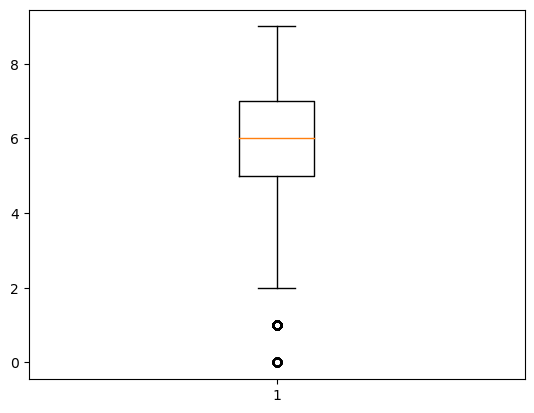

admission_type_id | number of outliers:  0.0
| number of outliers(z score method):  0.0


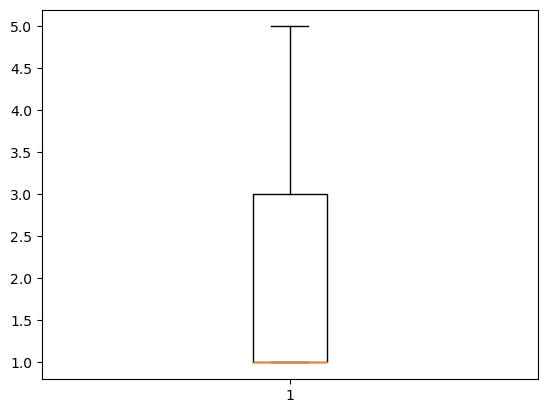

time_in_hospital | number of outliers:  0.020856059905703984
| number of outliers(z score method):  0.009503559212350928


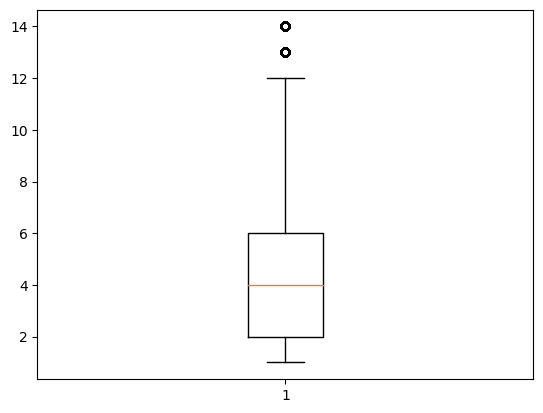

num_lab_procedures | number of outliers:  0.0013867061107515947
| number of outliers(z score method):  0.0004622353702505316


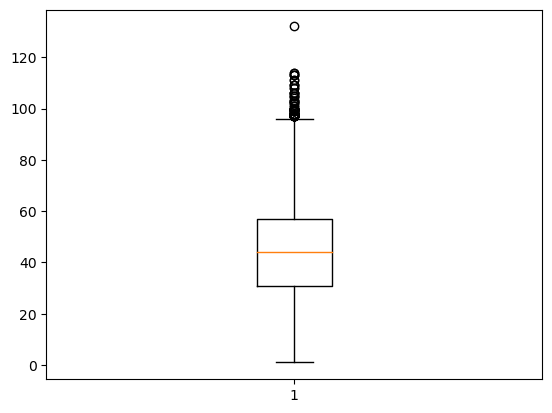

num_procedures | number of outliers:  0.05299066284552094
| number of outliers(z score method):  0.0


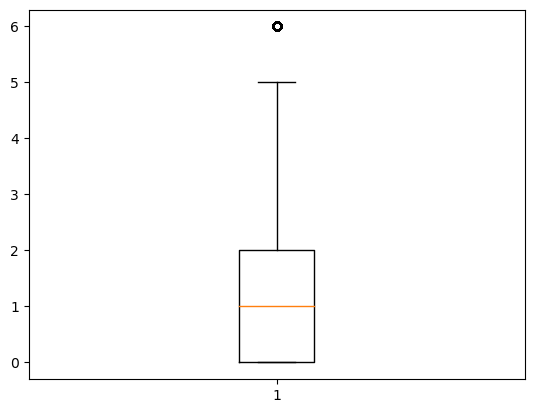

num_medications | number of outliers:  0.026439863178330407
| number of outliers(z score method):  0.014477211796246649


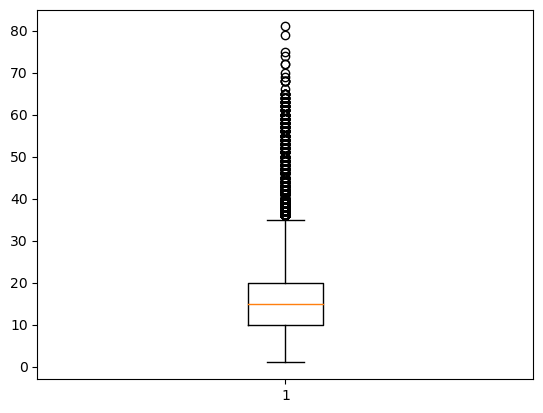

number_outpatient | number of outliers:  0.14351483775538504
| number of outliers(z score method):  0.021872977720255152


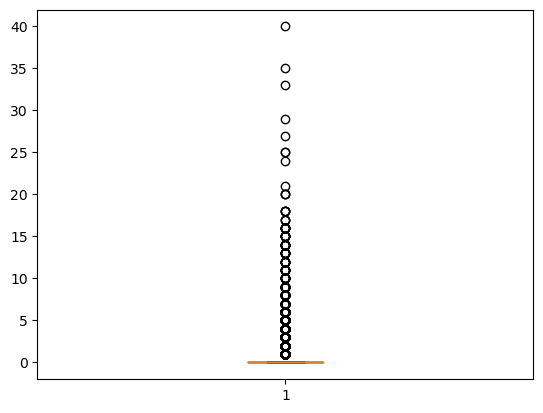

number_emergency | number of outliers:  0.08665988721456966
| number of outliers(z score method):  0.008320236664509569


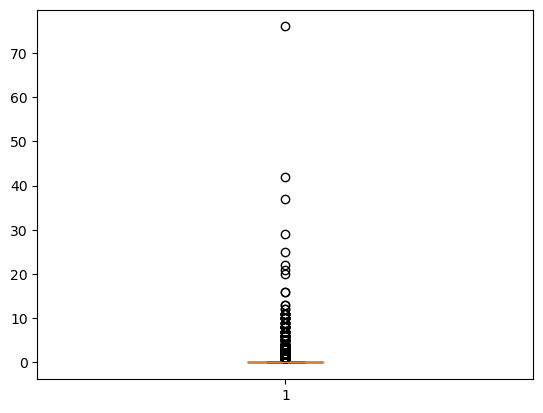

number_inpatient | number of outliers:  0.23659055190903208
| number of outliers(z score method):  0.015050383655357307


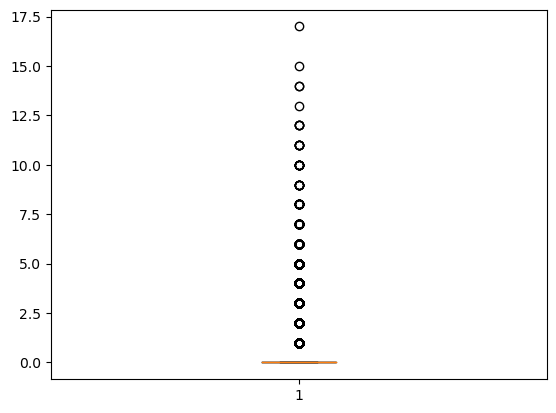

number_diagnoses | number of outliers:  0.0029767957844134235
| number of outliers(z score method):  0.0029767957844134235


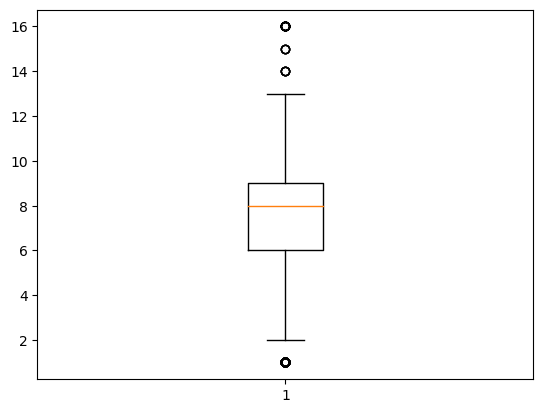

metformin | number of outliers:  0.20602754922806693
| number of outliers(z score method):  0.0


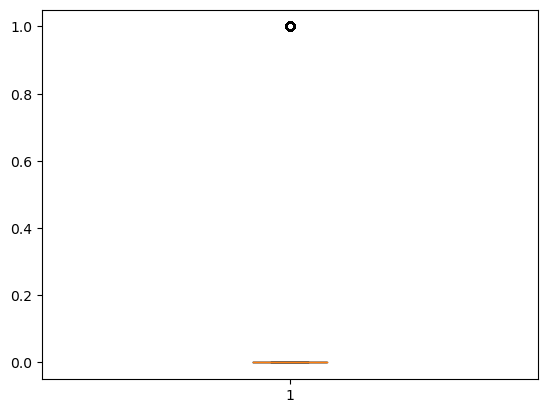

repaglinide | number of outliers:  0.013349357492835352
| number of outliers(z score method):  0.013349357492835352


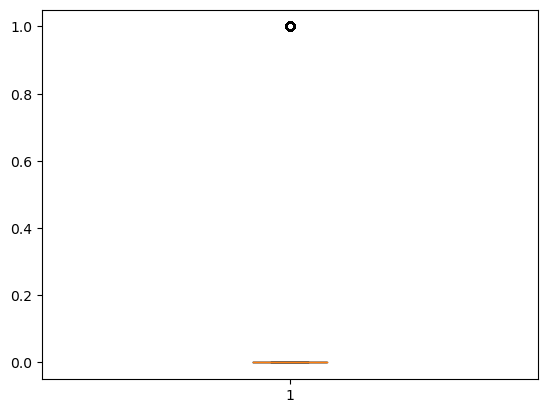

nateglinide | number of outliers:  0.007192382361098271
| number of outliers(z score method):  0.007192382361098271


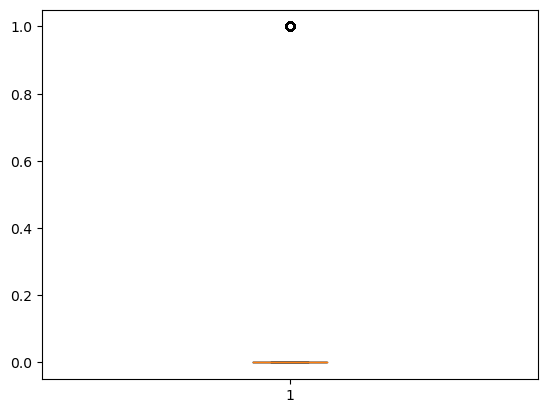

chlorpropamide | number of outliers:  0.0009614495701211057
| number of outliers(z score method):  0.0009614495701211057


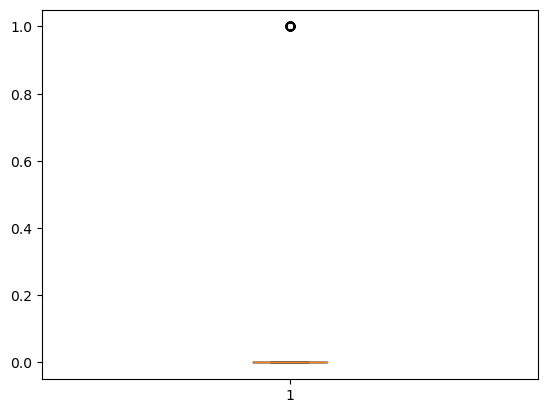

glimepiride | number of outliers:  0.051252657853378944
| number of outliers(z score method):  0.051252657853378944


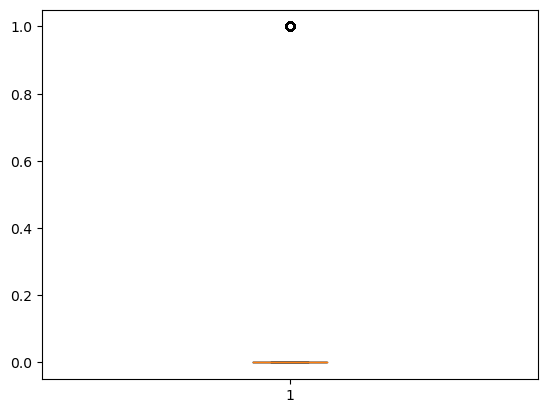

acetohexamide | number of outliers:  1.8489414810021264e-05
| number of outliers(z score method):  1.8489414810021264e-05


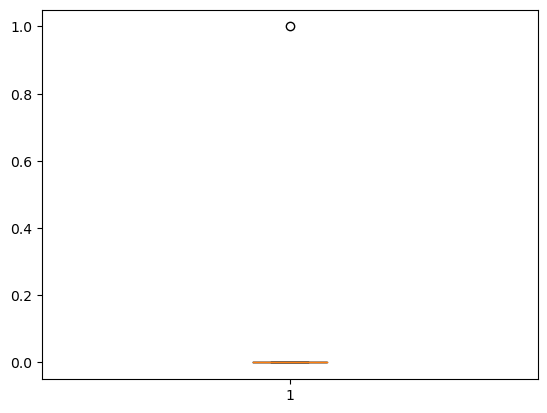

glipizide | number of outliers:  0.1264491078857354
| number of outliers(z score method):  0.0


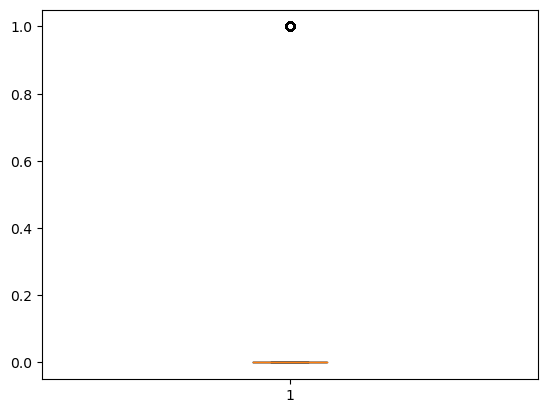

glyburide | number of outliers:  0.10703522233521309
| number of outliers(z score method):  0.0


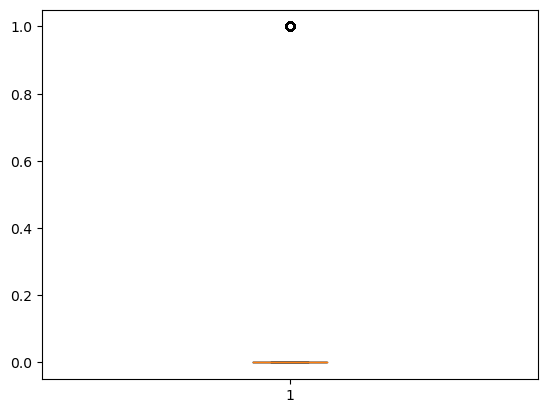

tolbutamide | number of outliers:  0.00027734122215031893
| number of outliers(z score method):  0.00027734122215031893


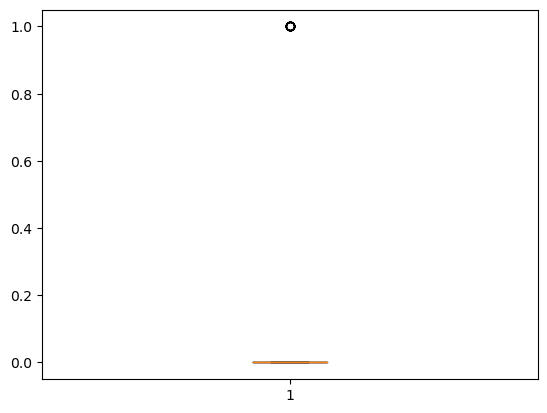

pioglitazone | number of outliers:  0.07358787094388462
| number of outliers(z score method):  0.07358787094388462


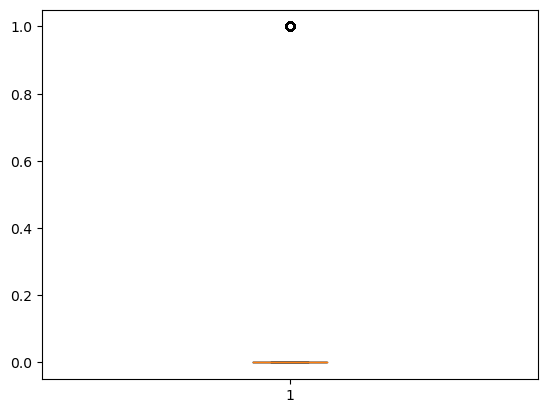

rosiglitazone | number of outliers:  0.06388092816862347
| number of outliers(z score method):  0.06388092816862347


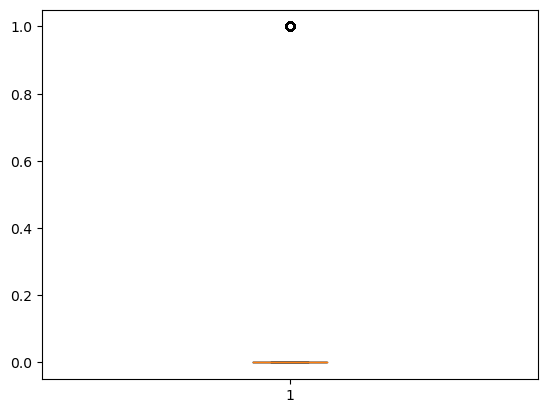

acarbose | number of outliers:  0.0029213275399833597
| number of outliers(z score method):  0.0029213275399833597


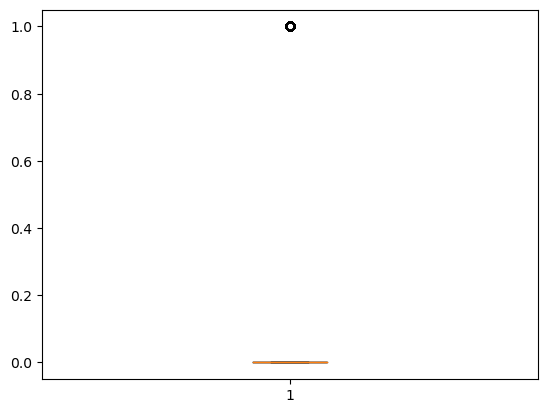

miglitol | number of outliers:  0.00027734122215031893
| number of outliers(z score method):  0.00027734122215031893


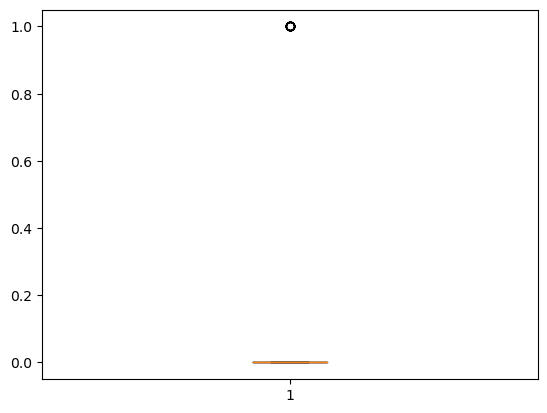

troglitazone | number of outliers:  3.697882962004253e-05
| number of outliers(z score method):  3.697882962004253e-05


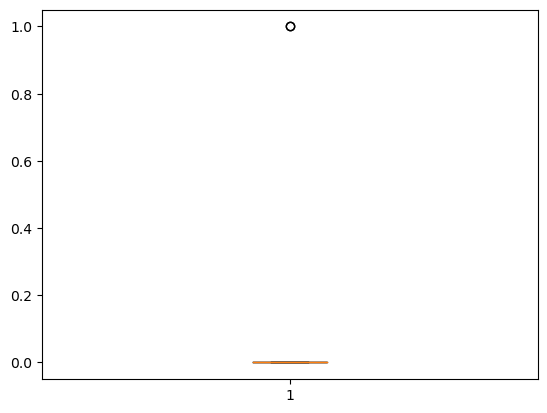

tolazamide | number of outliers:  0.0004437459554405103
| number of outliers(z score method):  0.0004437459554405103


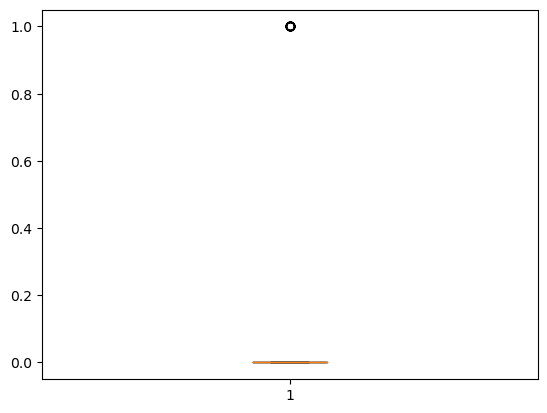

insulin | number of outliers:  0.0
| number of outliers(z score method):  0.0


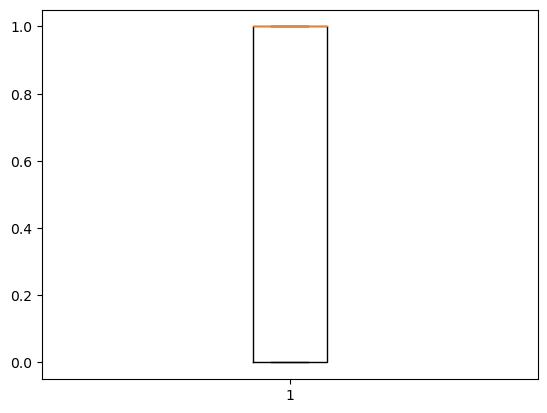

glyburide-metformin | number of outliers:  0.007081445872238143
| number of outliers(z score method):  0.007081445872238143


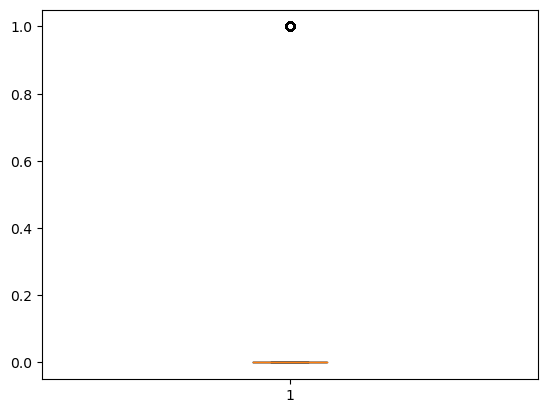

glipizide-metformin | number of outliers:  0.00012942590367014884
| number of outliers(z score method):  0.00012942590367014884


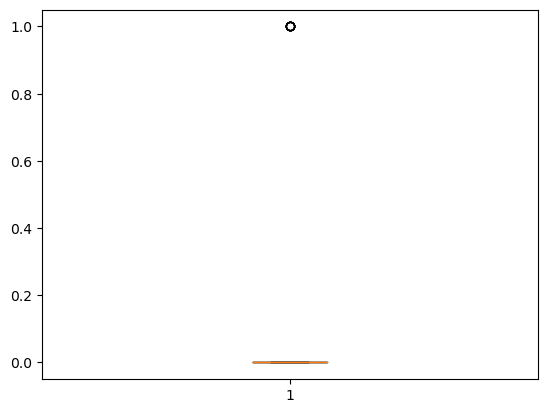

glimepiride-pioglitazone | number of outliers:  0.0
| number of outliers(z score method):  0.0


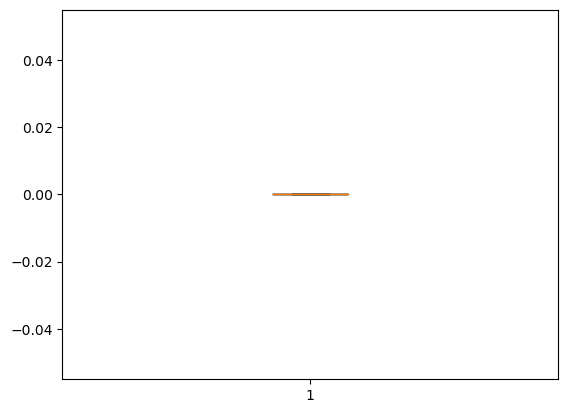

metformin-rosiglitazone | number of outliers:  1.8489414810021264e-05
| number of outliers(z score method):  1.8489414810021264e-05


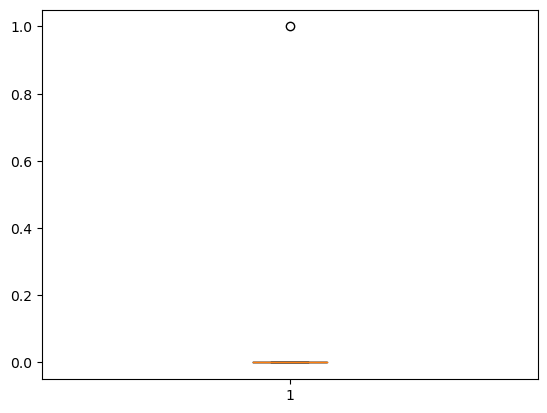

metformin-pioglitazone | number of outliers:  1.8489414810021264e-05
| number of outliers(z score method):  1.8489414810021264e-05


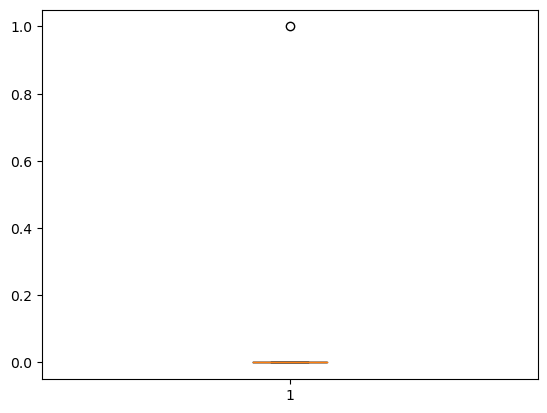

numchange | number of outliers:  0.0012018119626513821
| number of outliers(z score method):  0.014144402329666267


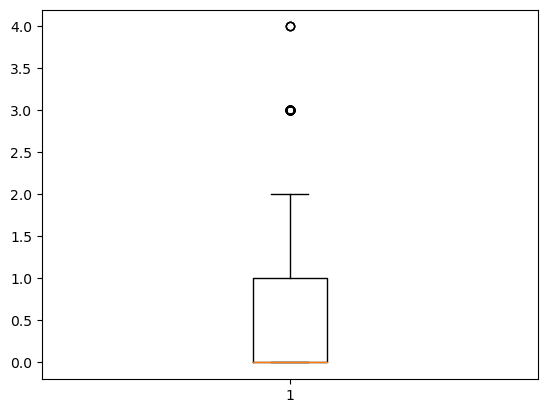

nummed | number of outliers:  0.014662105944346861
| number of outliers(z score method):  0.014662105944346861


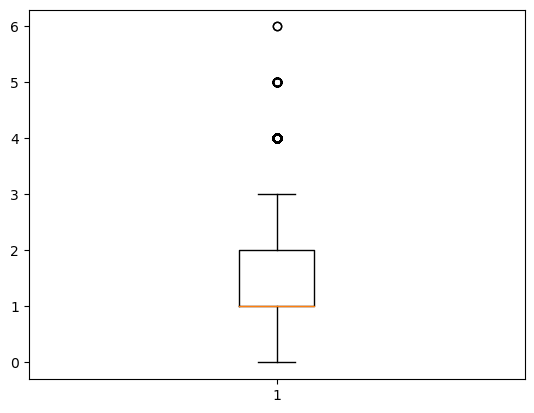

num_medications|time_in_hospital | number of outliers:  0.07184986595174263
| number of outliers(z score method):  0.023185726171766664


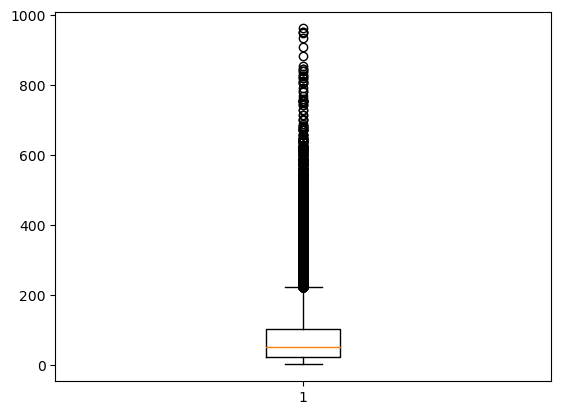

num_medications|num_procedures | number of outliers:  0.07876490709069058
| number of outliers(z score method):  0.023777387445687345


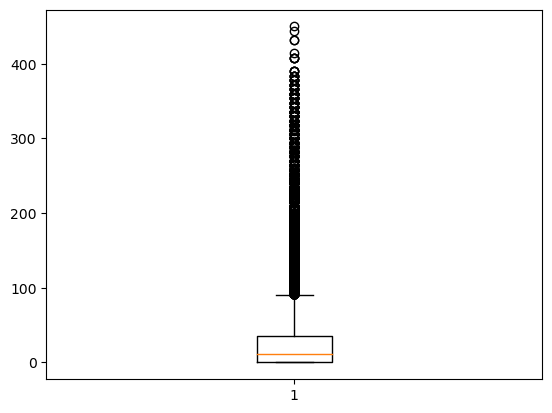

time_in_hospital|num_lab_procedures | number of outliers:  0.051585467319959326
| number of outliers(z score method):  0.019857631505962835


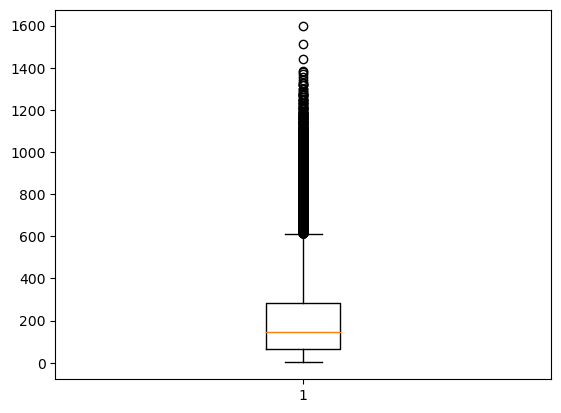

num_medications|num_lab_procedures | number of outliers:  0.043283720070259775
| number of outliers(z score method):  0.017601922899140244


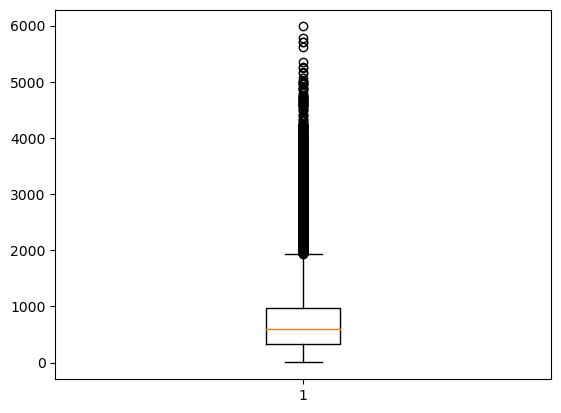

num_medications|number_diagnoses | number of outliers:  0.022224276601645557
| number of outliers(z score method):  0.013312378663215309


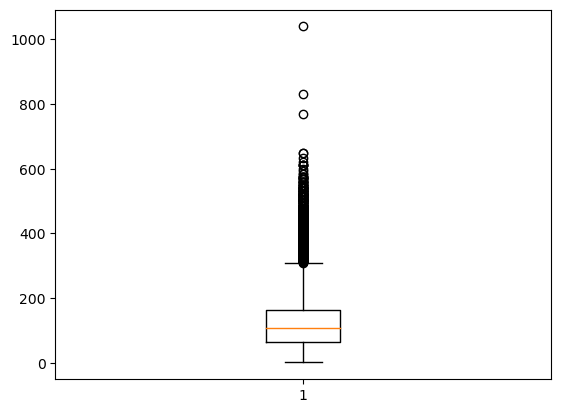

age|number_diagnoses | number of outliers:  0.0002588518073402977
| number of outliers(z score method):  0.0003143200517703615


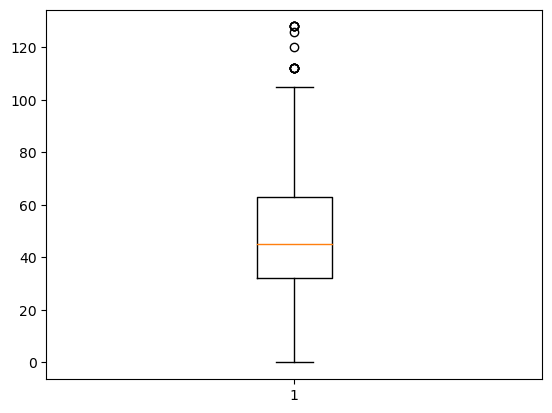

number_diagnoses|time_in_hospital | number of outliers:  0.03927151705648516
| number of outliers(z score method):  0.015420171951557734


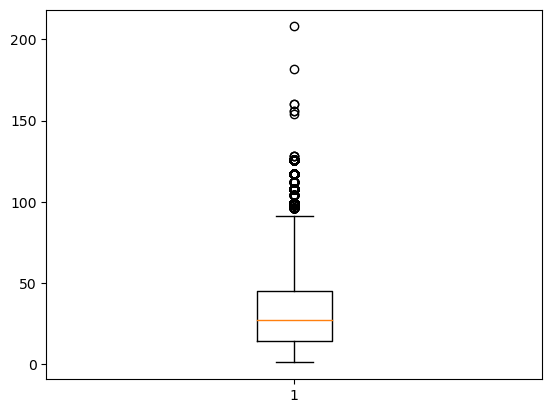

num_medications|numchange | number of outliers:  0.21421835998890634
| number of outliers(z score method):  0.0193029490616622


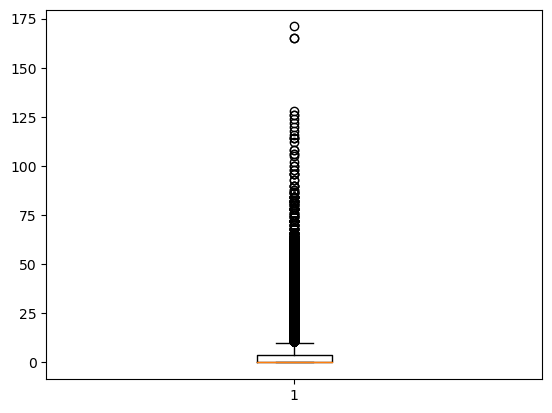

In [47]:
def plot_box_plots_print_percentage_of_outliers(train_data):
    for i in train_data._get_numeric_data().columns:
        Q1 = train_data[i].quantile(0.25)
        Q3 = train_data[i].quantile(0.75)
        IQR = Q3 - Q1
        print(i, '| number of outliers: ', ((train_data[i] < (Q1 - 1.5 * IQR)) | (train_data[i] > (Q3 + 1.5 * IQR))).sum()/len(train_data[i]))
        print('| number of outliers(z score method): ', sum(np.abs(sp.stats.zscore(train_data[i]))>3)/len(train_data[i]))
        plt.boxplot(train_data[i])
        plt.show()
plot_box_plots_print_percentage_of_outliers(train_data)

age


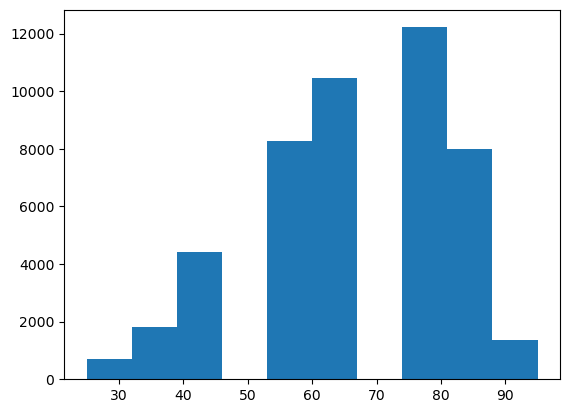

time_in_hospital


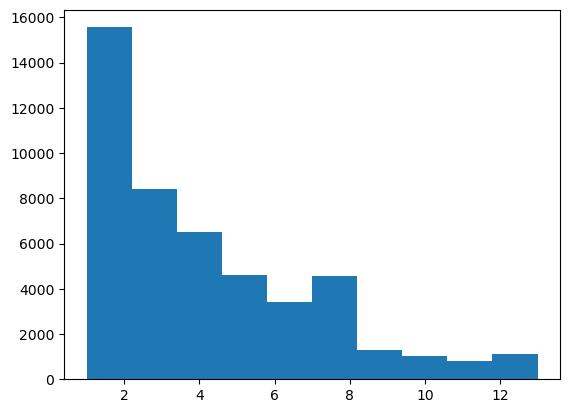

num_lab_procedures


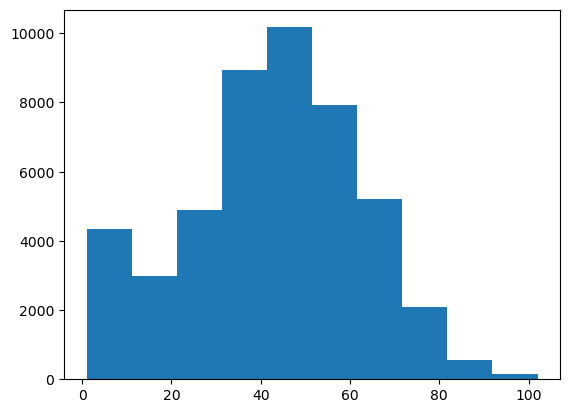

num_procedures


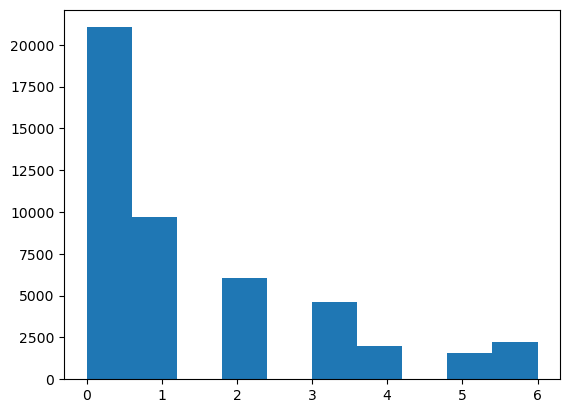

num_medications


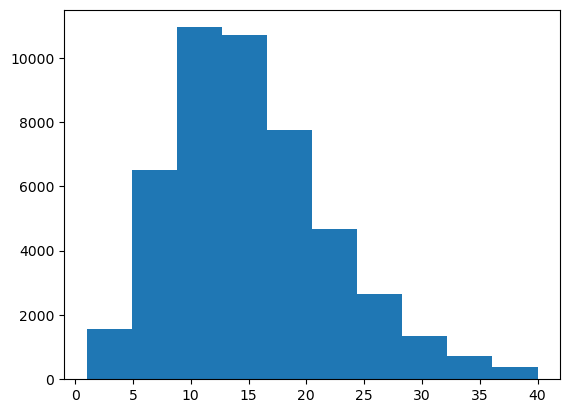

number_diagnoses


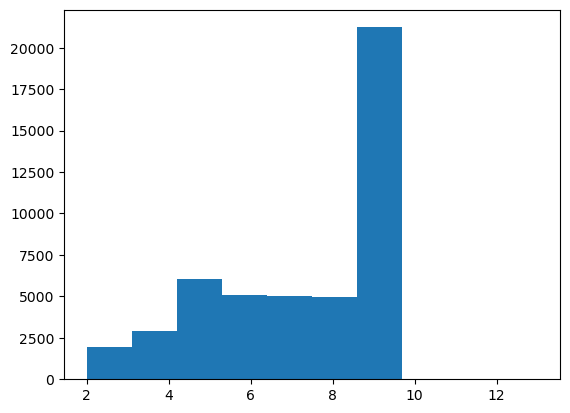

numchange


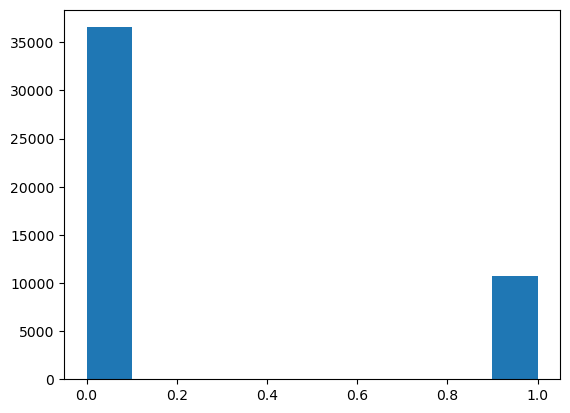

nummed


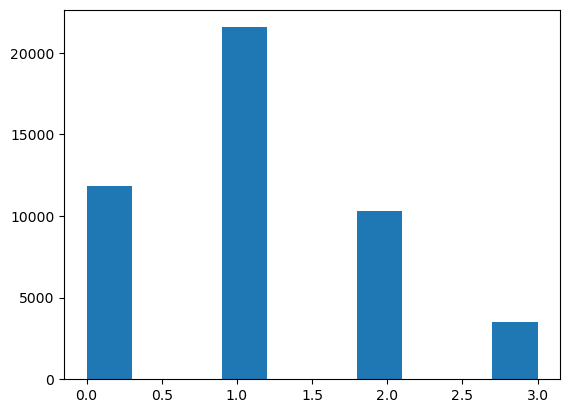

number_outpatient_log1p


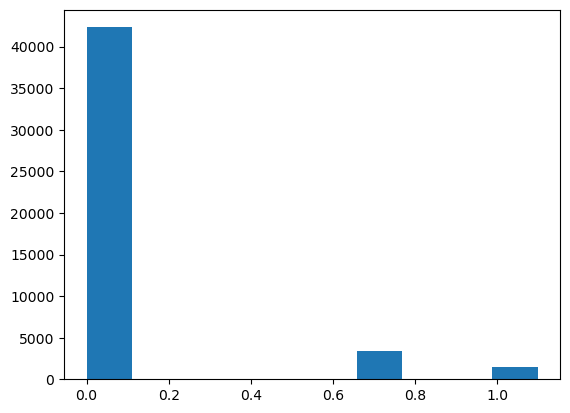

number_emergency_log1p


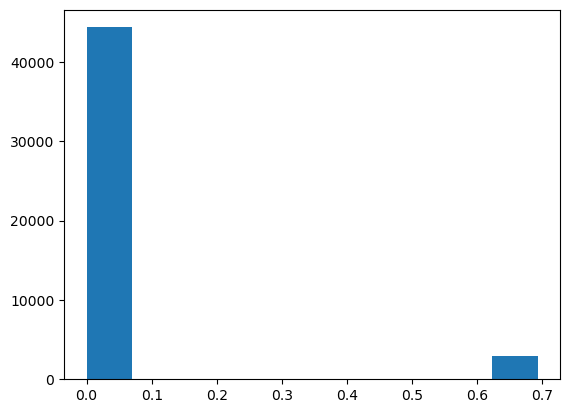

number_inpatient_log1p


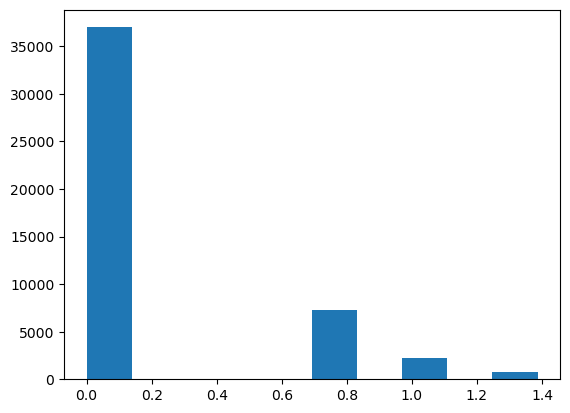

In [34]:
def plot_histograms_of_features(train_data):
    for i in train_data._get_numeric_data().columns:
        print(i)
        plt.hist(train_data[i], bins = 10)
        plt.show()
plot_histograms_of_features(train_data)

In [35]:
print(all_columns_train.shape, all_columns_test.shape)

(47249, 142) (30530, 142)


## Check the correlation between independent variables

In [140]:
pd.options.display.max_rows = 400
c = train_data._get_numeric_data().corr().abs()
s = c.unstack()
s.sort_values(ascending=False)

age                        age                          1.000000
admission_type_id          admission_type_id            1.000000
nummed                     nummed                       1.000000
numchange                  numchange                    1.000000
number_diagnoses           number_diagnoses             1.000000
num_medications            num_medications              1.000000
num_procedures             num_procedures               1.000000
num_lab_procedures         num_lab_procedures           1.000000
time_in_hospital           time_in_hospital             1.000000
service_utilization_log1p  service_utilization_log1p    1.000000
num_medications            time_in_hospital             0.438751
time_in_hospital           num_medications              0.438751
num_medications            num_procedures               0.325556
num_procedures             num_medications              0.325556
num_lab_procedures         time_in_hospital             0.314244
time_in_hospital         